In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

In [26]:
# Load the dataset with specified encoding
df = pd.read_csv('../dataset/train.csv', encoding='latin1')

# Display the first few rows to verify successful loading
print(df.head())


       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative          noon       60-70   

       Country  Population -2020  Land Area (Km²)  Density (P/Km²)  
0  Afghanistan          38928346         652860.0    

In [27]:

df = df[['text', 'sentiment']]

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


Missing values:
 text         1
sentiment    0
dtype: int64


C:\Users\haris\AppData\Local\Temp\ipykernel_36088\3334275760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


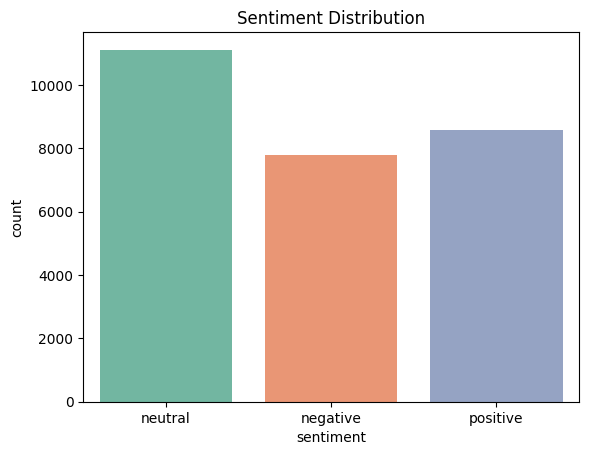

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


In [28]:
# Plot the distribution of sentiments
import seaborn as sns
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title('Sentiment Distribution')
plt.show()

# Check class imbalance
print(df['sentiment'].value_counts())


In [53]:
df = df[['text', 'sentiment']].dropna()

# Preprocess text (cleaning)
df['text'] = df['text'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True)

# Encode target variable (sentiment)
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')



In [60]:

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=32)

def create_model(embedding_dim=128, dropout_rate=0.1, l2_lambda=0.001, loss_function='sparse_categorical_crossentropy'):
    model = Sequential([
        Embedding(input_dim=1000, output_dim=embedding_dim, input_length=50),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dense(3, activation='softmax')  # Assuming 3 sentiment classes
    ])
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    return model



In [61]:
loss_functions = [
    'sparse_categorical_crossentropy'
]
for loss_func in loss_functions:
    print(f"\nTraining model with loss function: {loss_func}")
    model = create_model(loss_function=loss_func)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    model.save(f'sentiment_model_{loss_func}.h5')
    print(f"Model with loss {loss_func} saved as 'sentiment_model_{loss_func}.h5'")


Training model with loss function: sparse_categorical_crossentropy
Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4045 - loss: 1.4433 - val_accuracy: 0.4065 - val_loss: 1.3717
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4008 - loss: 1.3551 - val_accuracy: 0.4065 - val_loss: 1.3024
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3992 - loss: 1.2884 - val_accuracy: 0.4441 - val_loss: 1.2381
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4632 - loss: 1.2075 - val_accuracy: 0.5204 - val_loss: 1.0917
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5367 - loss: 1.0567 - val_accuracy: 0.5204 - val_loss: 1.0539
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5993 - loss: 0.9485 - val_accuracy: 0.5910 - val_loss: 0.9648
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6468 - loss: 0.8708 - val_accuracy: 0.6376 - val_loss: 0.9023
Epoch 8/20
687/687 ━━━━━━━━━━

Model with loss sparse_categorical_crossentropy saved as 'sentiment_model_sparse_categorical_crossentropy.h5'


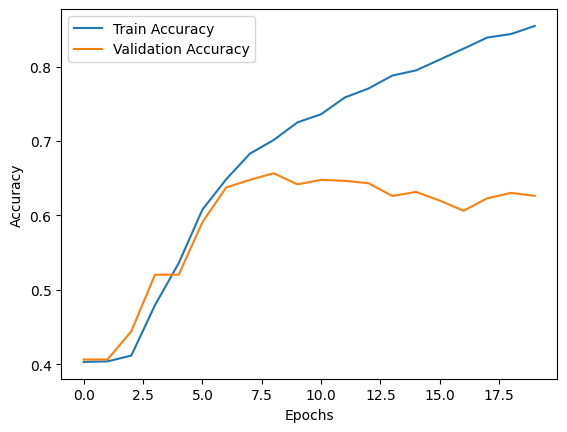

Validation Accuracy: 62.63%


In [62]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on validation data
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")